# Traffic Sign Regognition Trainer

This jupyter notebook is used to train the model.

Handling imports:

In [1]:
import numpy as np
np.random.seed(1337) # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import MaxPooling2D, Conv2D
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import glob
from skimage import io, transform, color, exposure
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

Using TensorFlow backend.


Setting parameters for the network and training:

In [2]:
batch_size = 32
nb_epoch = 50
nb_classes = 43

# input image dimensions
img_rows, img_cols = 32, 32

# number of convolutional filters to use 
conv_depth_1 = 32
conv_depth_2 = 64
conv_depth_3 = 128
hidden_size = 512

# size of pooling area for max pooling 
pool_size = (2, 2)

# convolution kernel size
kernel_size = (3, 3)

# percentage of deletion in dropout layers
dropout_conv = 0.25
dropout_hidden = 0.5

Making the images more uniform by preprocessing them:

In [3]:
# equalize histogram of each color channel
def equalize_hist(img):
    for k in range(3):
        img[:,:,k] = exposure.equalize_hist(img[:,:,k])
    return img

# stretch contrast of each color channel
def contrast_stretch(img):
    p2, p98 = np.percentile(img, (2, 98))
    for k in range(3):
        img[:,:,k] = exposure.rescale_intensity(img[:,:,k], in_range=(p2, p98))
    return img

def process_img(img):
    img = transform.resize(img, (img_rows, img_cols), mode='constant')
    img = contrast_stretch(img)
    #img = equalize_hist(img)
    return img

Load training images and labels:

The training images are located under *GTSRB/Final_Training/* , while the labels are extracted out of the file path.
These files can be downloaded [online](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [4]:
def get_class(img_path):
    return int(img_path.split(os.sep)[-2])

# Path to training data
train_dir = os.path.join('GTSRB', 'Final_Training', 'Images')
train_images_paths = glob.glob(
    os.path.join(train_dir, '*', '*.ppm'), recursive = True)

np.random.shuffle(train_images_paths)
train_images = []
train_labels = []

for filename in train_images_paths:
    try:
        img = process_img(io.imread(filename))
        train_images.append(img)
        label = get_class(filename)
        train_labels.append(label)
    except (IOError, OSError):
        print('missed', filename)
        pass
    
X_train = np.array(train_images, dtype='float32')
Y_train = np.eye(nb_classes, dtype='uint8')[train_labels] 

class:  5


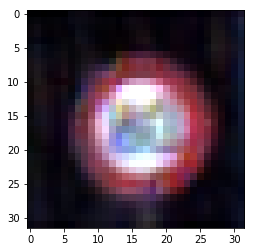

In [8]:
# To see if images got loaded correctly
i = 0
plt.imshow(X_train[i])
print('class: ', np.where(Y_train[i]==1)[0][0])

Load test images and labels.

The testing images are located under *GTSRB/Final_Test/* , while the labels are located in GT-final_test.csv.
These files can be downloaded online.

In [9]:
# Path to testing data
test_dir = os.path.join('GTSRB', 'Final_Test', 'Images')
test_images_paths = glob.glob(
    os.path.join(test_dir, '*.ppm'), recursive = True)

test_images = []
test_csv = pd.read_csv('GT-final_test.csv',sep=';')
test_labels = list(test_csv['ClassId'])

for filename in test_images_paths:
    try:
        img = process_img(io.imread(filename))
        test_images.append(img)
    except (IOError, OSError):
        print('missed', filename)
        pass
    
X_test = np.array(test_images, dtype='float32')
Y_test = np.eye(nb_classes, dtype='uint8')[test_labels] 

class:  16


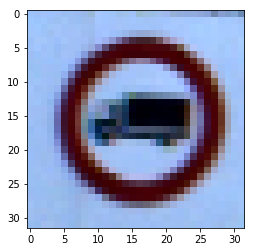

In [10]:
# To see if images got loaded correctly
i = 0
plt.imshow(X_test[i])
print('class: ', np.where(Y_test[i]==1)[0][0])

Further processing of input data and validation that it is all loaded up:

In [11]:
# Processing images for theano or tensorflow backend
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols) 
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols) 
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3) 
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3) 
    input_shape = (img_rows, img_cols, 3)
    
# Converting the input from bytes to floats
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 

# Normalising the input
X_train /= np.max(X_train)
X_test /= np.max(X_test)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(len(Y_train), 'train labels')
print(X_test.shape[0], 'test samples')
print(len(Y_test), 'test labels')

X_train shape: (39209, 32, 32, 3)
39209 train samples
39209 train labels
12630 test samples
12630 test labels


Data generation. Slightly rotates, shifts, shears and zoom images to get some more variation:

In [12]:
datagen = ImageDataGenerator(
              featurewise_center=False,
              featurewise_std_normalization=False,
              rotation_range=10,
              width_shift_range=0.1,
              height_shift_range=0.1,
              shear_range=0.3,
              zoom_range=0.2,
              horizontal_flip=False) 

datagen.fit(X_train)

Defining the whole network in keras:

In [13]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(conv_depth_1, (kernel_size[0], kernel_size[1]),
                 padding='same', input_shape=input_shape))
model.add(PReLU())
model.add(Conv2D(conv_depth_1, (kernel_size[0], kernel_size[1])))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Second convolutional layer
model.add(Conv2D(conv_depth_2, (kernel_size[0], kernel_size[1]), 
                 padding='same', kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Conv2D(conv_depth_2, (kernel_size[0], kernel_size[1]), 
                 kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Third convolutional layer
model.add(Conv2D(conv_depth_3, (kernel_size[0], kernel_size[1]), 
                 padding='same', kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Conv2D(conv_depth_3, (kernel_size[0], kernel_size[1]), 
                 kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Dense layer
model.add(Flatten())
model.add(Dense(hidden_size, kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Dropout(dropout_hidden))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

Compile the model:

In [14]:
model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

Let the network learn:

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train)/batch_size,
                              epochs=nb_epoch,
                              validation_data=(X_test, Y_test),
                              callbacks=[reduce_lr, ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/50
1226/1225 [==============================] - 25s - loss: 2.3936 - acc: 0.2975 - val_loss: 0.9851 - val_acc: 0.6753
Epoch 2/50
1226/1225 [==============================] - 23s - loss: 0.8295 - acc: 0.7315 - val_loss: 0.2171 - val_acc: 0.9332
Epoch 3/50
1226/1225 [==============================] - 23s - loss: 0.4071 - acc: 0.8721 - val_loss: 0.0980 - val_acc: 0.9701
Epoch 4/50
1226/1225 [==============================] - 23s - loss: 0.2642 - acc: 0.9193 - val_loss: 0.1024 - val_acc: 0.9659
Epoch 5/50
1226/1225 [==============================] - 23s - loss: 0.2109 - acc: 0.9369 - val_loss: 0.0815 - val_acc: 0.9764
Epoch 6/50
1226/1225 [==============================] - 22s - loss: 0.1770 - acc: 0.9457 - val_loss: 0.0990 - val_acc: 0.9721
Epoch 7/50
1226/1225 [==============================] - 21s - loss: 0.1468 - acc: 0.9570 - val_loss: 0.0753 - val_acc: 0.9758
Epoch 8/50
1226/1225 [==============================] - 21s - loss: 0.1427 - acc: 0.9569 - val_loss: 0.0443 - val_acc:

## Evaluation of the model:

In [16]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0464025507654
Test accuracy: 0.989627870226


dict_keys(['val_loss', 'lr', 'acc', 'loss', 'val_acc'])


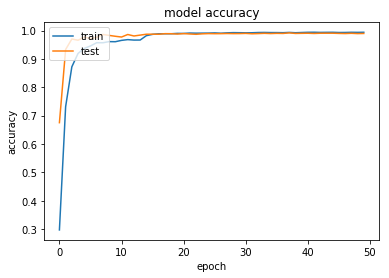

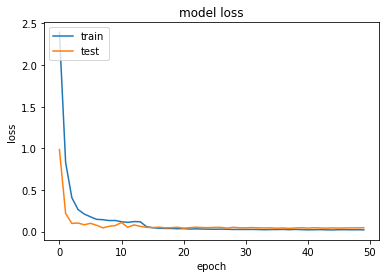

In [17]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
max(history.history['val_acc'])

0.99160728674036869

In [19]:
min(history.history['val_loss'])

0.038810424050781334

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 30, 30, 32)        28800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________